In [30]:
# import packages
import sys

import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax 
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [7]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.25.2
tensorflow version = 2.14.0


In [8]:
# setting up figure parameters
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (15.0/2, 20.0/2)

# Data preparation

In [129]:
# read in data
ORAp_t = '../data/sosstsst_control_regrid_monthly_3D_195801-201412.nc'
ORAp_h = '../data/sossheig_control_regrid_monthly_3D_195801-201412.nc'
ORAp_s = '../data/sosaline_control_regrid_monthly_3D_195801-201412.nc'
ORAp_m = '../data/somxl030_control_regrid_monthly_3D_195801-201412.nc'

ORA_SST = nc.Dataset(ORAp_t).variables['sst'][:]
ORA_SSH = nc.Dataset(ORAp_h).variables['ssh'][:]
ORA_SSS = nc.Dataset(ORAp_s).variables['sss'][:]
ORA_MLD = nc.Dataset(ORAp_m).variables['mxl'][:]

monthofYear = np.arange(1, np.shape(ORA_SST)[0]+1)
 
lat = nc.Dataset(ORAp_t).variables['lat'][:] #all nc files are regridded to same latlon values
lon = nc.Dataset(ORAp_t).variables['lon'][:]

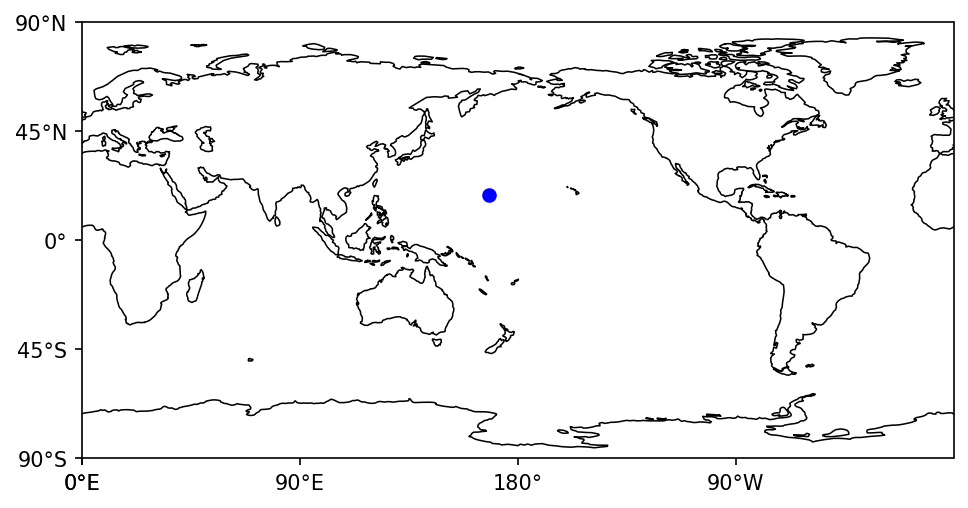

In [10]:
# pick a grid point
ilat = 90
ilon = 140

if ma.is_masked(ORA_SST[:,ilat,ilon]):
    print('Land! Try to pick a ocean grid :D')
else:
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(linewidth=.75)
    ax.set_global()

    ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)

    ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.plot(lon[ilon], lat[ilat], 'ob', markersize=6, transform=ccrs.PlateCarree())
    
    plt.show()

In [11]:
# calculate climatology
OSST_c = np.nanmean(np.array(ORA_SST[:,ilat,ilon]).reshape((int(len(ORA_SST[:,ilat,ilon])/12), 12)), axis=0)
OSSH_c = np.nanmean(np.array(ORA_SSH[:,ilat,ilon]).reshape((int(len(ORA_SSH[:,ilat,ilon])/12), 12)), axis=0)
OSSS_c = np.nanmean(np.array(ORA_SSS[:,ilat,ilon]).reshape((int(len(ORA_SSS[:,ilat,ilon])/12), 12)), axis=0)
OMLD_c = np.nanmean(np.array(ORA_MLD[:,ilat,ilon]).reshape((int(len(ORA_MLD[:,ilat,ilon])/12), 12)), axis=0)
OSST_cf = np.tile(OSST_c, int(len(ORA_SST[:,ilat,ilon])/12))
OSSH_cf = np.tile(OSSH_c, int(len(ORA_SSH[:,ilat,ilon])/12))
OSSS_cf = np.tile(OSSS_c, int(len(ORA_SSS[:,ilat,ilon])/12))
OMLD_cf = np.tile(OMLD_c, int(len(ORA_MLD[:,ilat,ilon])/12))

# remove climatology (just for predictors)
OSST_a = ORA_SST[:,ilat,ilon] - OSST_cf
OSSH_a = ORA_SSH[:,ilat,ilon] - OSSH_cf
OSSS_a = ORA_SSS[:,ilat,ilon] - OSSS_cf

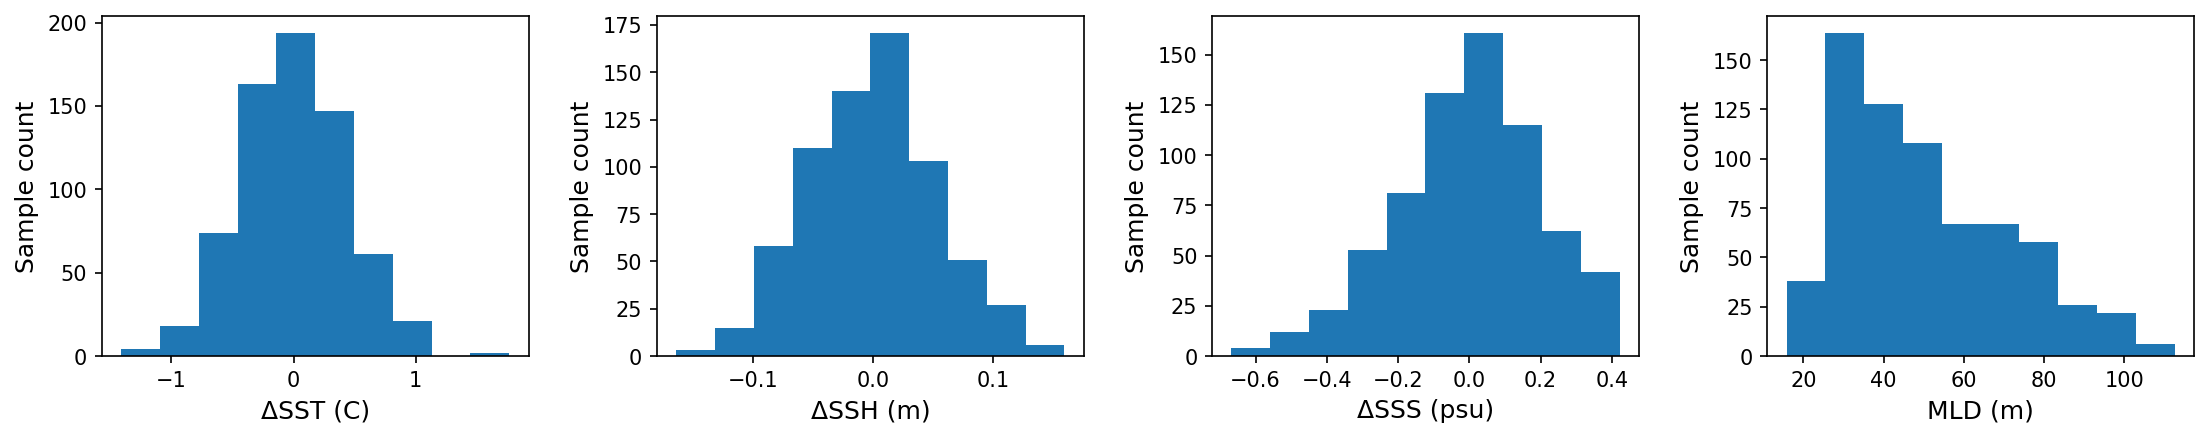

In [12]:
# check timeseries distribution
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_ylabel('Sample count')

axs[0].set_xlabel('\u0394SST (C)')
axs[1].set_xlabel('\u0394SSH (m)')
axs[2].set_xlabel('\u0394SSS (psu)')
axs[3].set_xlabel('MLD (m)')

axs[0].hist(OSST_a)
axs[1].hist(OSSH_a)
axs[2].hist(OSSS_a)
axs[3].hist(ORA_MLD[:,ilat,ilon])
        
fig.subplots_adjust(wspace=0.3)
plt.show()

In [13]:
# predictors and predictand
X = np.empty((len(OSST_a), 7))
X[:,:] = np.nan

X[:,0] = monthofYear
X[:,1] = OSST_cf
X[:,2] = OSSH_cf
X[:,3] = OSSS_cf
X[:,4] = OSST_a
X[:,5] = OSSH_a
X[:,6] = OSSS_a

y = np.copy(ORA_MLD[:,ilat,ilon])

label_names = ['MLD']
feature_list = ['month of year', 'SST - climatology', 'SSH - climatology', 'SSS - climatology', 'SST - anomaly', 'SSH - anomaly', 'SSS - anomaly']

In [28]:
# flatten the map into 2D (time,location) and create predictors and predictands
SST_tmp = ORA_SST.reshape(684, 45000)
SSH_tmp = ORA_SSH.reshape(684, 45000)
SSS_tmp = ORA_SSS.reshape(684, 45000)
MLD_tmp = ORA_MLD.reshape(684, 45000)

# calculate climatology
OSST_c_allgrid = np.nanmean(SST_tmp.reshape((int(np.shape(SST_tmp)[0]/12), 12, np.shape(SST_tmp)[1])), axis=0)
OSSH_c_allgrid = np.nanmean(SSH_tmp.reshape((int(np.shape(SSH_tmp)[0]/12), 12, np.shape(SSH_tmp)[1])), axis=0)
OSSS_c_allgrid = np.nanmean(SSS_tmp.reshape((int(np.shape(SSS_tmp)[0]/12), 12, np.shape(SSS_tmp)[1])), axis=0)
OMLD_c_allgrid = np.nanmean(MLD_tmp.reshape((int(np.shape(MLD_tmp)[0]/12), 12, np.shape(MLD_tmp)[1])), axis=0)
OSST_cf_allgrid = np.tile(OSST_c_allgrid, (int(np.shape(SST_tmp)[0]/12),1))
OSSH_cf_allgrid = np.tile(OSSH_c_allgrid, (int(np.shape(SSH_tmp)[0]/12),1))
OSSS_cf_allgrid = np.tile(OSSS_c_allgrid, (int(np.shape(SSS_tmp)[0]/12),1))
OMLD_cf_allgrid = np.tile(OMLD_c_allgrid, (int(np.shape(MLD_tmp)[0]/12),1))

# remove climatology (just for predictors)
OSST_a_allgrid = SST_tmp - OSST_cf_allgrid
OSSH_a_allgrid = SSH_tmp - OSSH_cf_allgrid
OSSS_a_allgrid = SSS_tmp - OSSS_cf_allgrid

X_allgrid = np.empty((np.shape(SST_tmp)[0], np.shape(SST_tmp)[1], 7))
X_allgrid[:,:,:] = np.nan

X_allgrid[:,:,0] = np.transpose(np.tile(monthofYear, (int(np.shape(SST_tmp)[1]),1)))
X_allgrid[:,:,1] = OSST_cf_allgrid
X_allgrid[:,:,2] = OSSH_cf_allgrid
X_allgrid[:,:,3] = OSSS_cf_allgrid
X_allgrid[:,:,4] = OSST_a_allgrid
X_allgrid[:,:,5] = OSSH_a_allgrid
X_allgrid[:,:,6] = OSSS_a_allgrid

y_allgrid = np.copy(MLD_tmp)

# Train/test set

In [29]:
# spliting train and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Training model based on the select grid point and test model performance on other grids
X_train = np.copy(X)
y_train = np.copy(y)

X_test = np.copy(X_allgrid)
y_test = np.copy(y_allgrid)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (684, 7)
Testing Features Shape: (684, 45000, 7)


In [38]:
# standardize inputs and output
standardize_input = lambda dat, x, s: (dat - x) / s

# Calculate mean and standard deviation of the training data
trainmean = X_train[:,1:].mean(axis=0)
trainstd = X_train[:,1:].std(axis=0)

# create new arrays for standardized data (coz monthofyear cannot be standardized, nor can it be removed from training/testing set)
Xtrain = np.empty(np.shape(X_train))
Xtest = np.empty(np.shape(X_test))

Xtrain[:,0] = X_train[:,0]
Xtest[:,:,0] = X_test[:,:,0]

Xtrain[:,1:] = standardize_input(X_train[:,1:], trainmean, trainstd)
Xtest[:,:,1:] = standardize_input(X_test[:,:,1:], trainmean, trainstd)

# A simple, fully-connected neutral network

In [401]:
# define parameters
n_units = 15 # number of units in each layer
bsize = 20 # Train on batches of 300 samples (chunk size)
n_epochs = 1000 # Epochs: run through all training data that many times. Order gets shuffled.


In [402]:
# define the model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# Input layer:
input_layer = tf.keras.layers.Input(shape=[Xtrain.shape[1:][0]-1]) # train on X except monthofyear

# First hidden layer: densely-connected layer with n_units units and activation function 'relu'.
hidden1 = layers.Dense(n_units, activation='relu')(input_layer)

# Second hidden layer:
hidden2 = layers.Dense(n_units, activation='relu')(hidden1)

# final layer:  just 1 node and no activation function
output_layer = layers.Dense(1, activation=None)(hidden2)
    
# complete and compile the model:
model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
model.compile(optimizer=keras.optimizers.Adam(0.01),  # Adam optimizer
            loss='mae',                               # mean absolute error = mae
            metrics=['mse'])                          # mean squared error = mse

In [403]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 15)                105       
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [404]:
# train the model
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=20,
                                                          restore_best_weights=True,
                                                          mode='auto',
                                                          verbose=1)

history = model.fit(Xtrain[:,1:], 
                    y_train, 
                    epochs=n_epochs, 
                    batch_size=bsize, 
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[early_stopping_callback],
                    verbose=2)

Epoch 1/1000
28/28 - 1s - loss: 42.7956 - mse: 2328.3857 - val_loss: 26.9317 - val_mse: 1195.2965 - 1s/epoch - 36ms/step
Epoch 2/1000
28/28 - 0s - loss: 19.0535 - mse: 634.1605 - val_loss: 16.9456 - val_mse: 442.1985 - 75ms/epoch - 3ms/step
Epoch 3/1000
28/28 - 0s - loss: 14.2994 - mse: 351.3565 - val_loss: 14.0715 - val_mse: 319.8240 - 74ms/epoch - 3ms/step
Epoch 4/1000
28/28 - 0s - loss: 12.0682 - mse: 250.4860 - val_loss: 11.2386 - val_mse: 208.8188 - 64ms/epoch - 2ms/step
Epoch 5/1000
28/28 - 0s - loss: 10.1795 - mse: 178.9939 - val_loss: 10.7445 - val_mse: 174.6311 - 66ms/epoch - 2ms/step
Epoch 6/1000
28/28 - 0s - loss: 8.8614 - mse: 135.1117 - val_loss: 9.4930 - val_mse: 144.8187 - 66ms/epoch - 2ms/step
Epoch 7/1000
28/28 - 0s - loss: 8.0270 - mse: 112.2245 - val_loss: 8.8315 - val_mse: 127.6937 - 67ms/epoch - 2ms/step
Epoch 8/1000
28/28 - 0s - loss: 7.5471 - mse: 103.2040 - val_loss: 8.7061 - val_mse: 125.0433 - 57ms/epoch - 2ms/step
Epoch 9/1000
28/28 - 0s - loss: 7.3700 - mse:

Epoch 71/1000
28/28 - 0s - loss: 5.9841 - mse: 71.5381 - val_loss: 7.5538 - val_mse: 92.0648 - 50ms/epoch - 2ms/step
Epoch 72/1000
28/28 - 0s - loss: 6.3265 - mse: 78.4829 - val_loss: 7.8065 - val_mse: 101.0269 - 48ms/epoch - 2ms/step
Epoch 73/1000
28/28 - 0s - loss: 6.1912 - mse: 73.6462 - val_loss: 7.4577 - val_mse: 88.4904 - 48ms/epoch - 2ms/step
Epoch 74/1000
28/28 - 0s - loss: 6.0591 - mse: 72.1558 - val_loss: 7.5362 - val_mse: 92.8800 - 49ms/epoch - 2ms/step
Epoch 75/1000
28/28 - 0s - loss: 6.0440 - mse: 72.5442 - val_loss: 7.5543 - val_mse: 89.8219 - 47ms/epoch - 2ms/step
Epoch 76/1000
28/28 - 0s - loss: 5.9052 - mse: 68.7459 - val_loss: 8.4867 - val_mse: 110.9878 - 54ms/epoch - 2ms/step
Epoch 77/1000
28/28 - 0s - loss: 6.1027 - mse: 73.3604 - val_loss: 7.2716 - val_mse: 85.8189 - 52ms/epoch - 2ms/step
Epoch 78/1000
28/28 - 0s - loss: 5.9544 - mse: 72.3812 - val_loss: 7.6204 - val_mse: 93.5044 - 50ms/epoch - 2ms/step
Epoch 79/1000
28/28 - 0s - loss: 5.8946 - mse: 68.5224 - val_l

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


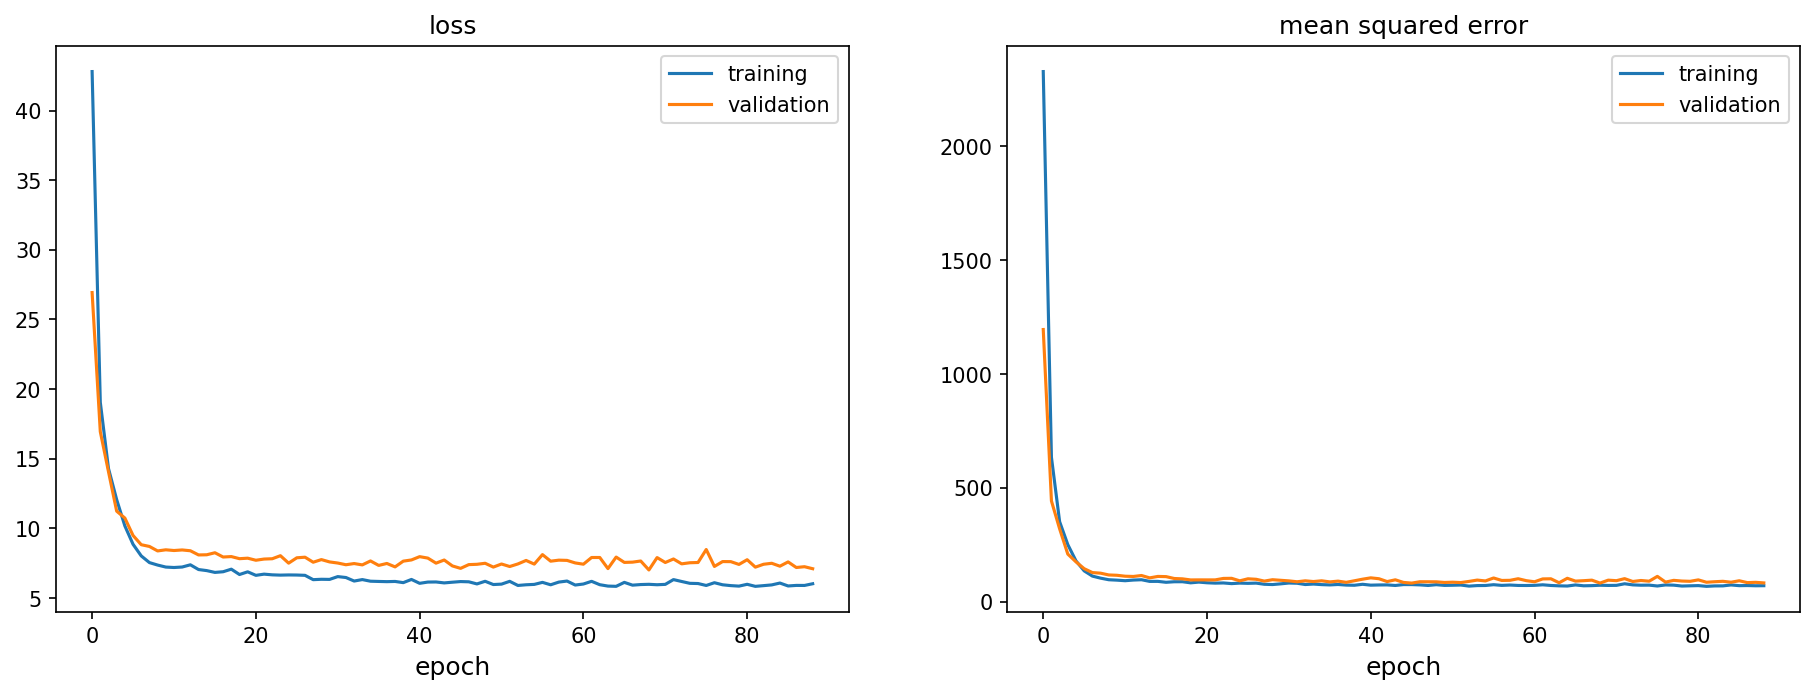

In [405]:
# plot the loss during training
print(history.history.keys())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.title('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mse'],label = 'training')
plt.plot(history.history['val_mse'], label = 'validation')
plt.title('mean squared error')
plt.xlabel('epoch')
plt.legend()

plt.show()

## Make predictions

In [406]:
# make predictions for training and testing set
y_pred_train = model.predict(Xtrain[:,1:])
y_pred_test = np.squeeze(model.predict(Xtest[:,:,1:]))

22/22 [==============================] - 2s 73ms/step


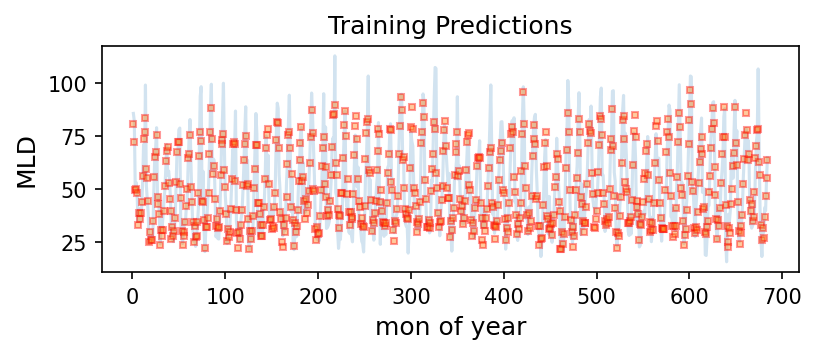

In [407]:
# plot training values
fig, ax = plt.subplots(figsize=(6, 2))

ax.plot(X[:,0], y_train, alpha=0.2)
ax.plot(Xtrain[:,0], y_pred_train, "s", markersize=3, alpha=0.4, linewidth=0.1, markeredgecolor="r")
ax.set_xlabel("mon of year")
ax.set_ylabel("MLD")

plt.title("Training Predictions")
plt.show()

## Evaluate this simple model

In [408]:
# calculate MLD climatology for evaluation
baseline = np.reshape(np.copy(OMLD_cf_allgrid), np.shape(ORA_MLD))

# Baseline errors (mean squared errors)
mse_baseline_errors = np.sqrt(np.mean((baseline - np.reshape(y_allgrid, np.shape(ORA_MLD)))**2, axis=0))
print('mse baseline error shape:', mse_baseline_errors.shape)

mse baseline error shape: (150, 300)


In [409]:
# calculate errors of predictions
mse_allgrid_errors = np.sqrt(np.mean(np.reshape(y_pred_test - y_test, np.shape(ORA_MLD))**2, axis=0))

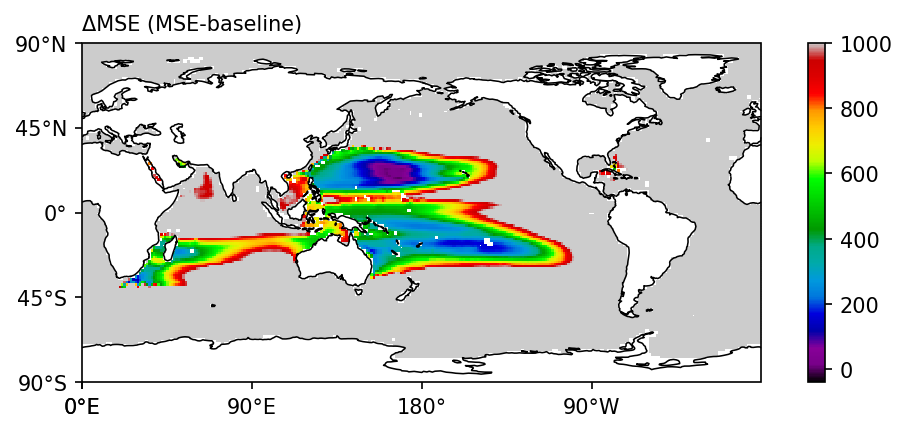

In [410]:
# plot differences between errors and baseline errors on maps
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# mse
plt.figure(figsize=(8,3))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(linewidth=.75)
ax.set_global()
ax.set_title('\u0394MSE (MSE-baseline)', loc='left', fontsize=10)

ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(lat_formatter)

image = ax.pcolor(lon, lat, mse_allgrid_errors-mse_baseline_errors, transform=ccrs.PlateCarree(), cmap='nipy_spectral', vmin=-40, vmax=1000)
fig.colorbar(image, ax=ax)

plt.show()

# A more complex model

In [412]:
# define parameters
n_units = 10 # number of units in each layer
bsize = 18 # split timeseries into how many chunks
n_epochs = 1000 # Epochs: run through all training data that many times. Order gets shuffled.
dropout_rate = 0.05 # 5% of units to drop
patience = 20

In [413]:
# define the model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# Input layer:
input_layer = layers.Input(shape=[Xtrain.shape[1:][0]-1]) # train on X except monthofyear

# Normalization layer:
normalizer = layers.Normalization(axis=(1,))
norm_layer = normalizer(input_layer)

# First hidden layer: densely-connected layer with n_units units and activation function 'relu'.
hidden1 = layers.Dense(n_units, activation='relu')(norm_layer)

# A dropout layer:
dropout_layer = layers.Dropout(rate=dropout_rate)(hidden1)

# Second hidden layer:
hidden2 = layers.Dense(n_units, activation='relu')(dropout_layer)

# Third hidden layer:
hidden3 = layers.Dense(n_units, activation='relu')(hidden2)

# final layer:  just 1 node and no activation function
output_layer = layers.Dense(1, activation=None)(hidden3)
    
# complete and compile the model:
model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
model.compile(optimizer=keras.optimizers.Adam(0.01),  # Adam optimizer
            loss='mae',                               # mean absolute error = mae
            metrics=['mse'])                          # mean squared error = mse

In [414]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 10)                70        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                             

In [415]:
# train the model
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=patience,
                                                          restore_best_weights=True,
                                                          mode='auto',
                                                          verbose=1)

history = model.fit(Xtrain[:,1:], 
                    y_train, 
                    epochs=n_epochs, 
                    batch_size=bsize, 
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[early_stopping_callback],
                    verbose=2)

Epoch 1/1000
31/31 - 1s - loss: 46.7194 - mse: 2624.9285 - val_loss: 39.3550 - val_mse: 1989.2112 - 1s/epoch - 41ms/step
Epoch 2/1000
31/31 - 0s - loss: 23.7696 - mse: 906.4084 - val_loss: 17.2282 - val_mse: 462.7657 - 82ms/epoch - 3ms/step
Epoch 3/1000
31/31 - 0s - loss: 15.4473 - mse: 405.9382 - val_loss: 13.1342 - val_mse: 273.0737 - 67ms/epoch - 2ms/step
Epoch 4/1000
31/31 - 0s - loss: 12.1861 - mse: 244.9852 - val_loss: 10.8536 - val_mse: 191.1653 - 178ms/epoch - 6ms/step
Epoch 5/1000
31/31 - 0s - loss: 10.3042 - mse: 180.5862 - val_loss: 9.9114 - val_mse: 158.8093 - 110ms/epoch - 4ms/step
Epoch 6/1000
31/31 - 0s - loss: 8.8370 - mse: 134.8234 - val_loss: 8.7084 - val_mse: 120.1746 - 101ms/epoch - 3ms/step
Epoch 7/1000
31/31 - 0s - loss: 8.1880 - mse: 118.5731 - val_loss: 8.7145 - val_mse: 119.2506 - 82ms/epoch - 3ms/step
Epoch 8/1000
31/31 - 0s - loss: 8.2308 - mse: 120.9244 - val_loss: 9.0702 - val_mse: 129.0489 - 81ms/epoch - 3ms/step
Epoch 9/1000
31/31 - 0s - loss: 8.1273 - ms

Epoch 70: early stopping


dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


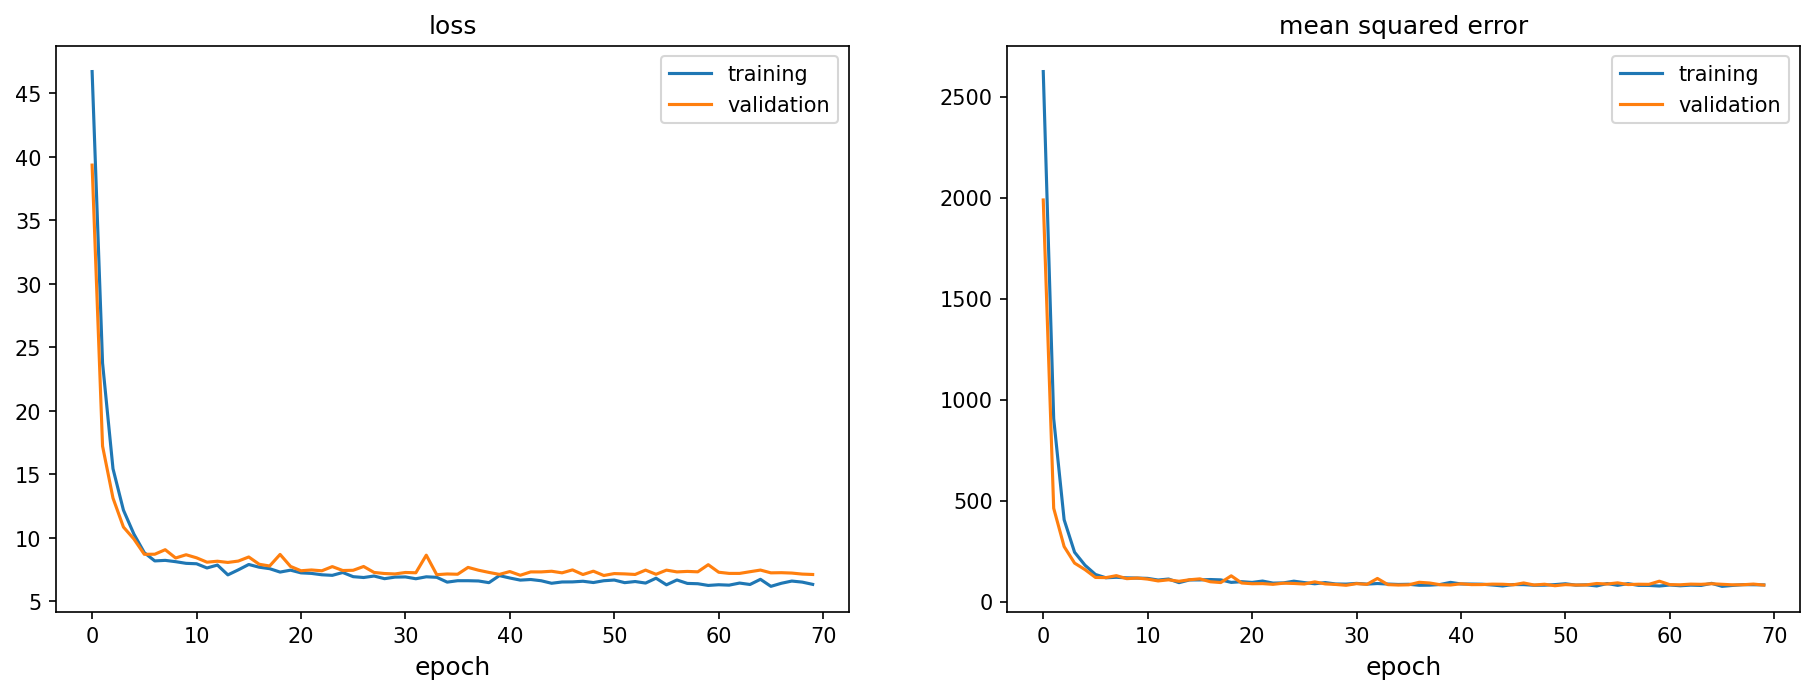

In [416]:
# plot the loss during training
print(history.history.keys())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.title('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mse'],label = 'training')
plt.plot(history.history['val_mse'], label = 'validation')
plt.title('mean squared error')
plt.xlabel('epoch')
plt.legend()


plt.show()

## Make predictions

In [417]:
# make predictions for training and testing set
y_pred_train = model.predict(Xtrain[:,1:])
y_pred_test = np.squeeze(model.predict(Xtest[:,:,1:]))

22/22 [==============================] - 6s 241ms/step


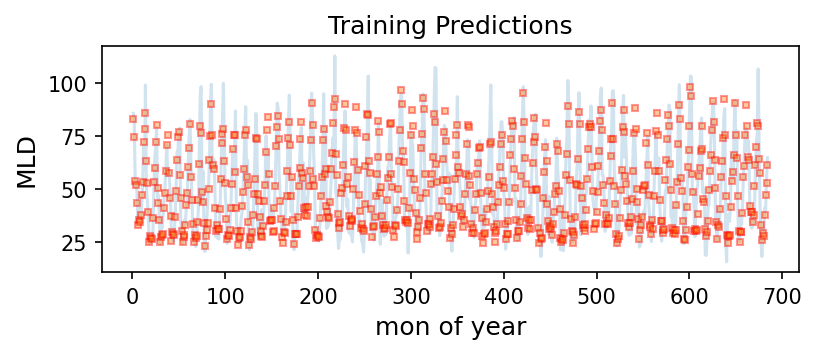

In [418]:
# plot training values
fig, ax = plt.subplots(figsize=(6, 2))

ax.plot(X[:,0], y_train, alpha=0.2)
ax.plot(Xtrain[:,0], y_pred_train, "s", markersize=3, alpha=0.4, linewidth=0.1, markeredgecolor="r")
ax.set_xlabel("mon of year")
ax.set_ylabel("MLD")

plt.title("Training Predictions")
plt.show()

## Evaluate this complex model

In [425]:
# calculate MLD climatology for evaluation
baseline = np.reshape(np.copy(OMLD_cf_allgrid), np.shape(ORA_MLD))

# Baseline errors (mean squared errors)
mse_baseline_errors = np.sqrt(np.mean((baseline - np.reshape(y_allgrid, np.shape(ORA_MLD)))**2, axis=0))
print('mse baseline error shape:', mse_baseline_errors.shape)

mse baseline error shape: (150, 300)


In [419]:
# calculate errors of predictions
mse_allgrid_errors = np.sqrt(np.mean(np.reshape(y_pred_test - y_test, np.shape(ORA_MLD))**2, axis=0))

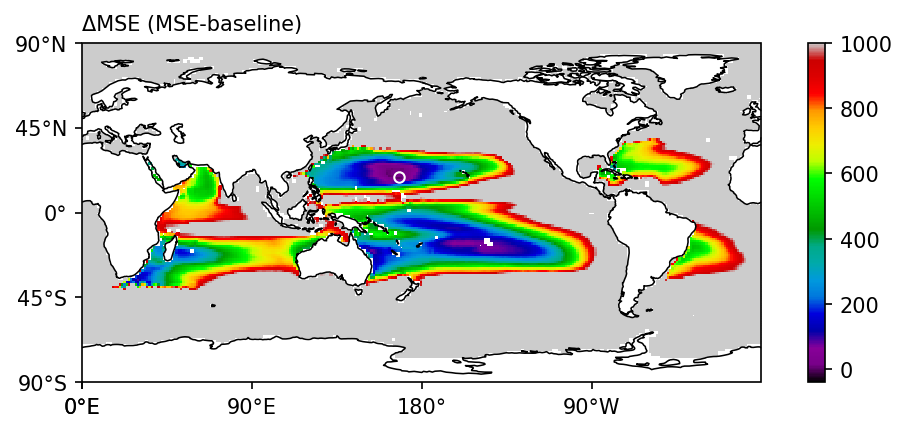

In [422]:
# plot differences between errors and baseline errors on maps
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# mse
plt.figure(figsize=(8,3))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(linewidth=.75)
ax.set_global()
ax.set_title('\u0394MSE (MSE-baseline)', loc='left', fontsize=10)

ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(lat_formatter)

image = ax.pcolor(lon, lat, mse_allgrid_errors-mse_baseline_errors, transform=ccrs.PlateCarree(), cmap='nipy_spectral', vmin=-40, vmax=1000)
fig.colorbar(image, ax=ax)

ax.plot(lon[ilon], lat[ilat], 'ow', markersize=5, markerfacecolor='none', transform=ccrs.PlateCarree())

plt.show()

In [427]:
mse_baseline_errors[ilat,ilon:ilon+2]

array([10.42385812, 10.86940974])

In [428]:
mse_allgrid_errors[ilat,ilon:ilon+2]

array([ 8.39806234, 13.55373689])